<a href="https://colab.research.google.com/github/GrzegorzSzczepanek/deep_learning_fun/blob/main/training_on_trigonometric_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt


In [116]:
start = 0
end = 1000
step = 0.02

X = torch.arange(start, end, step)
y = np.sin(X)
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40000, 40000, 10000, 10000)

In [117]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader= DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [118]:
print(len(train_dataloader.dataset))  # Number of training samples
print(len(test_dataloader.dataset))

40000
10000


In [119]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(100, 7))
  plt.scatter(train_data, train_labels, c="b", s=0.04, label="training data")
  plt.scatter(test_data, test_labels, c="g", s=0.04, label="testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=0.04, label="predictions")

  plt.legend(prop={"size": 14})

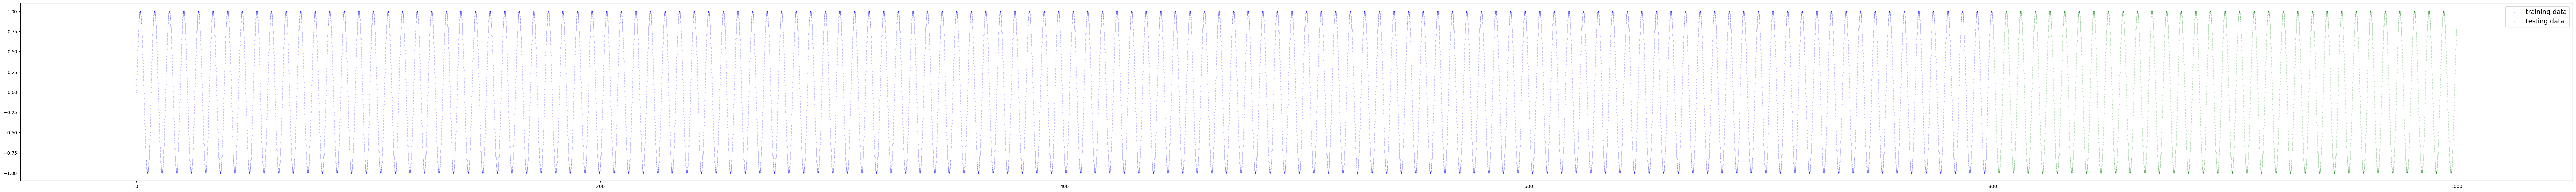

In [120]:
plot_predictions()

In [121]:
class Sinus_Model(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_block1 = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)

    )

  def forward(self, x):
    return self.layer_block1(x)

model = Sinus_Model(1, 8, 1)
model, model.state_dict()

(Sinus_Model(
   (layer_block1): Sequential(
     (0): Linear(in_features=1, out_features=8, bias=True)
     (1): ReLU()
     (2): Linear(in_features=8, out_features=8, bias=True)
     (3): ReLU()
     (4): Linear(in_features=8, out_features=1, bias=True)
   )
 ),
 OrderedDict([('layer_block1.0.weight',
               tensor([[ 0.4386],
                       [ 0.4128],
                       [-0.6757],
                       [-0.3722],
                       [-0.5252],
                       [-0.5405],
                       [ 0.6591],
                       [-0.4112]])),
              ('layer_block1.0.bias',
               tensor([ 0.4697,  0.6849,  0.9625, -0.6423,  0.7380, -0.4603,  0.0471, -0.2549])),
              ('layer_block1.2.weight',
               tensor([[-0.0607,  0.3388, -0.2741, -0.0451, -0.2275,  0.0096,  0.0695,  0.0142],
                       [ 0.1724, -0.3065,  0.2301,  0.3423, -0.0924,  0.0385, -0.2493,  0.0837],
                       [ 0.1993,  0.0768, -0.1196,

In [122]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [125]:
for batch_idx, (data, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}")
    print("Sample Data:", data)
    print("Sample Labels:", labels)
    break  # Stop after printing the first batch to avoid excessive output

Batch 0 - Data shape: torch.Size([8]), Labels shape: torch.Size([8])
Sample Data: tensor([230.4200,  16.9600, 621.4200, 196.5600, 339.2200, 608.1000, 240.7000,
        114.6200])
Sample Labels: tensor([-0.8837, -0.9496, -0.5772,  0.9779, -0.0719, -0.9797,  0.9330,  0.9988])


In [136]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    # X, y = X.to(device), y.to(device)
    X = X.unsqueeze(1)
    y.unsqueeze(1)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(y_pred, dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [137]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # X, y = X.to(device), y.to(device)
      X = X.unsqueeze(1)
      y.unsqueeze(1)
      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [140]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn)
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )

        # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
  return results

In [141]:
from timeit import default_timer as timer

NUM_EPOCHS = 5
start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6380 | train_acc: 0.0000 | test_loss: 0.6351 | test_acc: 0.0000
Epoch: 2 | train_loss: 0.6379 | train_acc: 0.0000 | test_loss: 0.6376 | test_acc: 0.0000
Epoch: 3 | train_loss: 0.6376 | train_acc: 0.0000 | test_loss: 0.6352 | test_acc: 0.0000
Epoch: 4 | train_loss: 0.6377 | train_acc: 0.0000 | test_loss: 0.6356 | test_acc: 0.0000
Epoch: 5 | train_loss: 0.6376 | train_acc: 0.0000 | test_loss: 0.6361 | test_acc: 0.0000
Total training time: 34.649 seconds


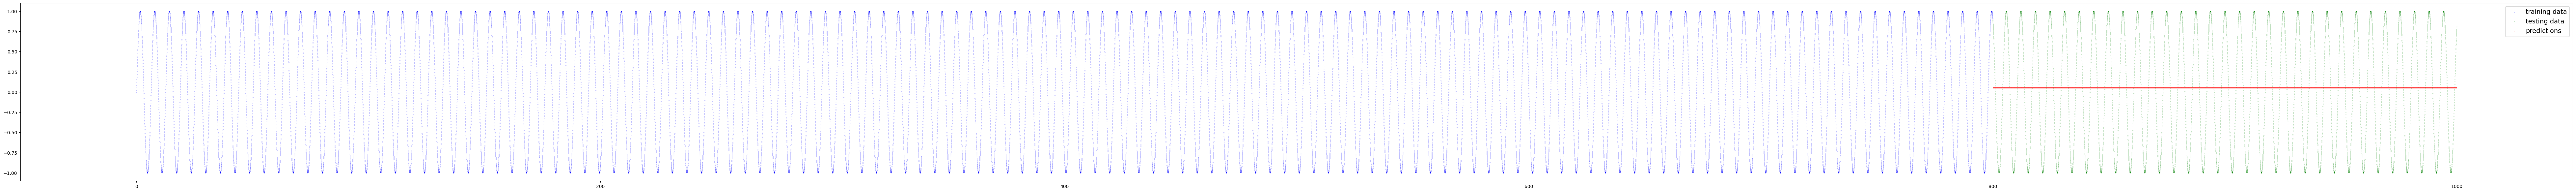

In [145]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  X_test = X_test.unsqueeze(1)
  y_preds = model(X_test)

plot_predictions(predictions=y_preds)